In [1]:
# NOTE: You don't have to run this cell.
# If you have the steam_text_content.csv and steam_data.csv file downloaded locally, this cell is safe to delete.
# This is only for the Google Colab setup.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
DESCRIPTION_CSV_PATH = "./drive/MyDrive/dl/datasets/steam/steam_description_data.csv" # Do replace with your own path
DATA_CSV_PATH = "./drive/MyDrive/dl/datasets/steam/steam.csv"

In [4]:
description_df = pd.read_csv(DESCRIPTION_CSV_PATH)
data_df = pd.read_csv(DATA_CSV_PATH)

## DataFrame Preprocessing

In [5]:
description_df

,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...
...,...,...,...,...
27329,1065230,"<img src=""https://steamcdn-a.akamaihd.net/stea...","<img src=""https://steamcdn-a.akamaihd.net/stea...",The Room of Pandora is a third-person interact...
27330,1065570,Have you ever been so lonely that no one but y...,Have you ever been so lonely that no one but y...,Cyber Gun is a hardcore first-person shooter w...
27331,1065650,<strong>Super Star Blast </strong>is a space b...,<strong>Super Star Blast </strong>is a space b...,Super Star Blast is a space based game with ch...
27332,1066700,Pursue a snow-white deer through an enchanted ...,Pursue a snow-white deer through an enchanted ...,Pursue a snow-white deer through an enchanted ...


In [6]:
data_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


In [7]:
description_df.iloc[0]['detailed_description']

"Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."

In [8]:
desc_df_subset = description_df[['steam_appid', 'detailed_description']]
data_df_subset = data_df[['appid', 'genres']]

merged_df = pd.merge(desc_df_subset, data_df_subset, left_on='steam_appid', right_on='appid', how='inner')

df = merged_df.dropna(subset=['detailed_description', 'genres'])
df

,steam_appid,detailed_description,appid,genres
0,10,Play the world's number 1 online action game. ...,10,Action
1,20,One of the most popular online action games of...,20,Action
2,30,Enlist in an intense brand of Axis vs. Allied ...,30,Action
3,40,Enjoy fast-paced multiplayer gaming with Death...,40,Action
4,50,Return to the Black Mesa Research Facility as ...,50,Action
...,...,...,...,...
27070,1065230,"<img src=""https://steamcdn-a.akamaihd.net/stea...",1065230,Adventure;Casual;Indie
27071,1065570,Have you ever been so lonely that no one but y...,1065570,Action;Adventure;Indie
27072,1065650,<strong>Super Star Blast </strong>is a space b...,1065650,Action;Casual;Indie
27073,1066700,Pursue a snow-white deer through an enchanted ...,1066700,Adventure;Casual;Indie


## Preprocessing Game Descriptions

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_most_common_words(input_text) -> None:
  """ plots 20 of the most common words from `input_text`
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  common_words = word_counts.most_common(20)
  words, counts = zip(*common_words)

  plt.bar(words, counts)
  plt.xticks(rotation=45)
  plt.title("20 Most Common Words")
  plt.show()

In [10]:
import numpy as np

def plot_vocab_coverage(input_text) -> None:
  """ plots the cumulative coverage of the vocabulary
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  counts = np.array(sorted(word_counts.values(), reverse=True))
  total = counts.sum()
  cumulative_coverage = np.cumsum(counts) / total

  # Plot coverage
  plt.plot(cumulative_coverage)
  plt.xlabel("Vocabulary size")
  plt.ylabel("Cumulative coverage")
  plt.title("Vocab Coverage Curve")
  plt.grid(True)
  plt.show()

  for threshold in [0.8, 0.85, 0.9, 0.92, 0.95, 0.98]:
      idx = np.argmax(cumulative_coverage >= threshold) + 1
      print(f"{threshold*100:.0f}% coverage with vocab size = {idx}")

As expected, the vocabulary is dominated by filler words like 'the', 'and', 'of', etc.

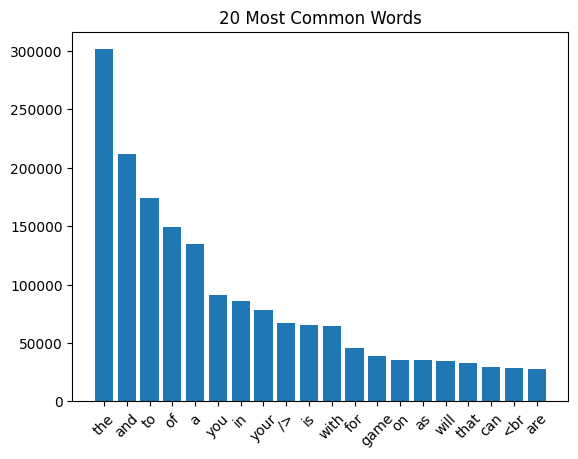

In [11]:
plot_most_common_words(df['detailed_description'].to_list())

The preprocessing pipeline is condensed into the `preprocess_text` function. In chronological order, the steps we took to preprocess the movie plots are:  
* standardize all texts to lower case
* remove possibly existing html tags (i.e. '<>')
* remove punctuation but keep apostrophe
* remove stopwords but keep negation words like 'not', 'no' or 'nor' that might add to meaning
* lemmatization
* standardise spaces between the texts

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[^\w\s']", '', text)

    tokens = text.split()

    # remove stopwords but keep negations like 'not', 'no', 'nor'
    filtered_tokens = [w for w in tokens if w not in stop_words or w in ['not', 'no', 'nor']]

    lemmatized = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
preprocessed_texts = [preprocess_text(p) for p in df['detailed_description'].to_list()]

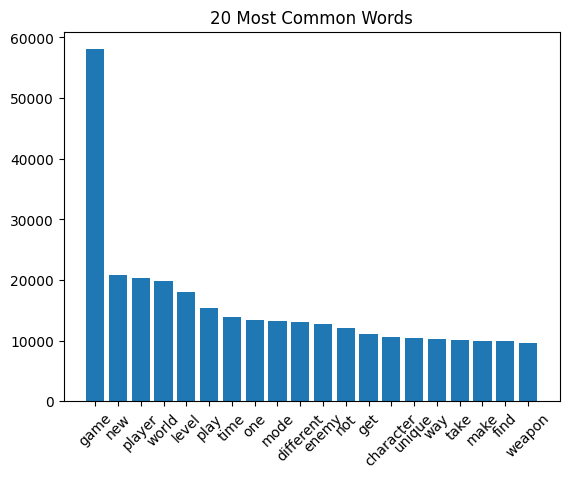

In [14]:
plot_most_common_words(preprocessed_texts)

Here, the word 'game' dominates the vocabulary by a significant margin. But in this case, the word 'game' probably adds no value into classifying the genre of the game itself because these data samples are all games. Hence it is just more noise.

For that matter, we remove the word 'game' from our data samples.

In [15]:
preprocessed_texts = [re.sub(r'\bgame\b', '', p) for p in preprocessed_texts]

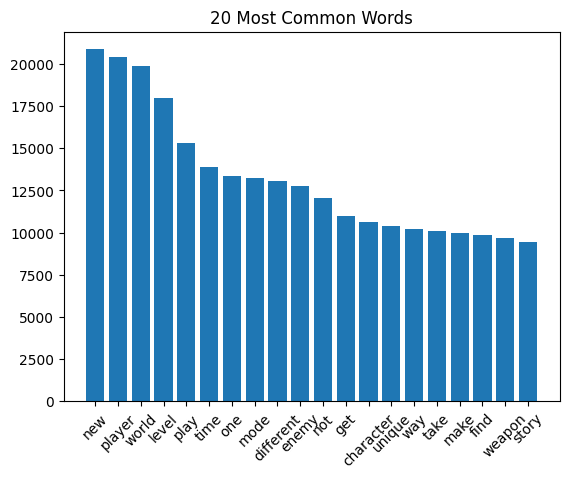

In [16]:
plot_most_common_words(preprocessed_texts)

The word frequency distribution now looks much better, eliminating potential noise in the dataset.

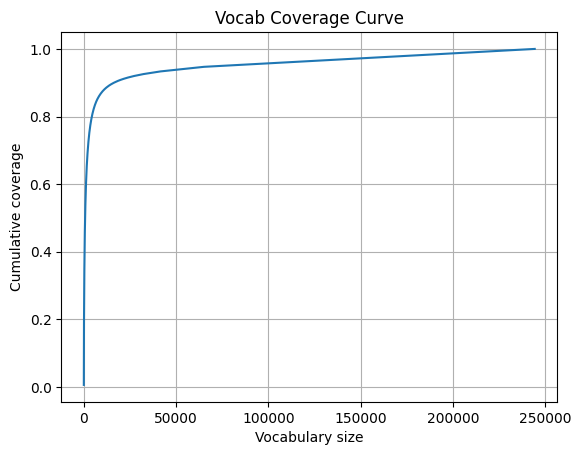

80% coverage with vocab size = 4346
85% coverage with vocab size = 7208
90% coverage with vocab size = 16295
92% coverage with vocab size = 27298
95% coverage with vocab size = 75075
98% coverage with vocab size = 176607


In [17]:
plot_vocab_coverage(preprocessed_texts)

To achieve 95% coverage, we would need to include around 72,000 words from the vocabulary. Which for this case might be too large.

We'll settle for a vocabulary coverage of somewhere between 92% to 95%. To do that, we'll have a vocabulary size of 40,000.

We build our own tokenizer with a maximum vocab size of 40,004 (40,000 + 4) consisting of:
* 40,000 words from the ~90% vocabulary coverage as shown in the cell above
* 4 special tokens `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`, which are padding tokens, unknown words (out of vocabulary tokens), start of sentence, and end of sentence respectively.

In [18]:
BATCH_SIZE = 32
RANDOM_SEED = 42
VOCAB_SIZE = 40004
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2 # note that this split is not absolute, it is relative to the training data that is already split by TEST_SPLIT

In [19]:
words = [w for t in preprocessed_texts for w in t.split()]

freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE - 4)]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

def encode(t):
    tokens = t.split()
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

## Preprocessing Game Categories to Classify

In this step, we decide what the labels in the classification problem will be and how they are represented for the model to learn from.

In [20]:
print(df["genres"].value_counts())

genres
Action;Indie                                                        1852
Casual;Indie                                                        1482
Action;Adventure;Indie                                              1229
Adventure;Indie                                                     1170
Action;Casual;Indie                                                 1004
                                                                    ... 
Casual;Free to Play;Indie;Racing;Strategy                              1
Free to Play;Indie;RPG;Early Access                                    1
Action;Adventure;Indie;Massively Multiplayer;Simulation;Strategy       1
Indie;Massively Multiplayer;Racing;Simulation                          1
Action;Adventure;Indie;Racing;RPG                                      1
Name: count, Length: 1552, dtype: int64


In [21]:
def plot_genre_freq_distribution(genre_counts):
  """ similar to plotting the most common words, but for categories. This time only the top 10 categories.
  """
  common_words = genre_counts.most_common(10)
  genre, counts = zip(*common_words)

  plt.bar(genre, counts)
  plt.xticks(rotation=45)
  plt.title("Top 10 Genre Frequency Distribution")
  plt.show()

In [22]:
df["genres"]

,genres
0,Action
1,Action
2,Action
3,Action
4,Action
...,...
27070,Adventure;Casual;Indie
27071,Action;Adventure;Indie
27072,Action;Casual;Indie
27073,Adventure;Casual;Indie


In [23]:
genre_list = []

for genre_str in df["genres"]:
  temp = genre_str.split(';')
  temp = [x.lower() for x in temp]
  genre_list.append(temp)

In [24]:
genre_list[20:30]

[['action'],
 ['action'],
 ['action', 'free to play', 'strategy'],
 ['action', 'adventure'],
 ['action'],
 ['action', 'free to play'],
 ['indie'],
 ['action'],
 ['action'],
 ['action']]

Since the less popular genres will blow the total class number up making the classification problem very sparse, we collect the top 10 most common genres from the plot.

In [25]:
from collections import Counter

EXCLUDE_GENRES = ["early access", "free to play"] # 'early access' and 'free to play' are not game genres.

all_genres = [g for sublist in genre_list for g in sublist]

genre_counts = Counter(all_genres)

top_genres = [g for g, _ in genre_counts.most_common() if g not in EXCLUDE_GENRES][:10]
print(top_genres)

['indie', 'action', 'casual', 'adventure', 'strategy', 'simulation', 'rpg', 'sports', 'racing', 'violent']


If a game only classifies in genres that are not in the top 10, we label its genre as 'other'.

In [26]:
genre_list = [[g for g in sublist if g in top_genres] for sublist in genre_list]

for i in range(len(genre_list)):
  if len(genre_list[i]) == 0:
    genre_list[i] = ["other"]

**NOTE: The label frequency distribution is imbalanced. Something has to be done during training (e.g. using weight class during training)**

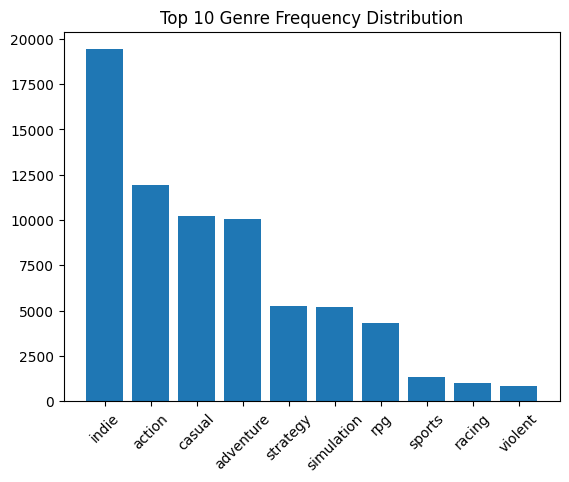

In [27]:
filtered_counts = Counter({g: c for g, c in genre_counts.items() if g not in EXCLUDE_GENRES})
plot_genre_freq_distribution(filtered_counts)

We encode the classes into a vector of length 11. Each index in the vector represents a genre of the game to classify.

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genre_list)

print("All possible genres:", mlb.classes_)

All possible genres: ['action' 'adventure' 'casual' 'indie' 'other' 'racing' 'rpg' 'simulation'
 'sports' 'strategy' 'violent']


An example of a label's vector representation can be seen below.

In [29]:
print("Sample label: ", genre_list[27070])
print("The corresponding vector representation: ", y[27070])

Sample label:  ['adventure', 'casual', 'indie']
The corresponding vector representation:  [0 1 1 1 0 0 0 0 0 0 0]


## Preparing the DataLoader

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class GameDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

With the current train, val, test data split, the distribution of data samples will look consist of 15% test, 17% validation, 68% training data.

This is given that `TEST_SPLIT = 0.15` and `VAL_SPLIT = 0.2`.

In [31]:
from sklearn.model_selection import train_test_split

train_plots, test_plots, y_train, y_test = train_test_split(preprocessed_texts, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
 # split training set again into train/val
train_plots, val_plots, y_train, y_val = train_test_split(train_plots, y_train, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = GameDataset(train_plots, y_train)
val_ds = GameDataset(val_plots, y_val)
test_ds = GameDataset(test_plots, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Inspecting the DataLoader

In [32]:
data_iter = iter(train_dl)
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 403])
torch.Size([32, 11])


Each training batch has 32 samples (due to `BATCH_SIZE = 32`).

Each training input is of size 375 in this specific sample due to padding. Note that different batches may have different input lengths. We'll observe this in the next cell where the input length is 401.

There are consistently 11 labels throughout training, i.e. the top 10 genres + `other`.

In [33]:
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 688])
torch.Size([32, 11])
